In [1]:
# Run Functional connectivity on HBN data
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
from nilearn import input_data
from nilearn import signal
from nilearn import masking
import numpy as np
import pandas as pd
import glob
import os
import nibabel as nib
from os.path import exists
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
#matplotlib.use('agg') # supposed to avoid memory leak - add to .py version of code when not running as notebook

/home/users/mayay/.local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
# Load subject fmri data
# Define paths:
projectdir = '/scratch/groups/jyeatman/HBN_FC/'
inputdir = projectdir + 'input/'
space = 'volume' # volume or surface analysis

datadir = projectdir + space + '/statMaps/'
analysesdir = projectdir + space + '/analyses/'
imagedir =  projectdir + space + 'images/'

#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.basename(x) for x in glob.glob(inputdir + '/sub-*')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')

Found 126 subjects in inputdir


In [59]:
# define parameters and ROIs
roi_names = ['VWFA1','VWFA2']
roi_coords = [(-39,-71,-8),(-41,-60,-8)] # Lerma-Usabiaga et al., PNAS, 2018
#roi_coords = [(-44,-69,-12),(-41,-49,-20)] # White et al., PNAS 2019

# For debugging
roi_names = ['VWFA2']
roi_coords = [(-41,-60,-8)]

roi_radius = 7 # 7mm to replicate my CONN analysis
# These are the coordinates from the paper, ...
# VWFA1 --> average of real words > checkerboards/scrambled words/phase scrambled words
# VWFA2 --> real words > pseudowords

t_r = 0.8

# Which task
task = 'rest' # options are 'rest' or 'movie'

overwrite = False
saveFigs = False # Save png files of connectivity maps
saveMaps = False # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = False

droptp = 5
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# stat parameters
z_thresh = 0.25
cluster_thresh = 100 # Try to get clean maps

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])

# Load subject list
subject_file = projectdir + 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
sub_list = pd.read_csv(subject_file)
subs = sub_list['participant_id']
subs = subs[37:38]

# Allocate empty array for group data - N subjects * n volumes
# FIXME - which file to load to get the right volume dimensions?! 
#for roi_num in range(len(roi_names)):

    
sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

group_map = np.zeros(shape = (len(subs),white_left[0].shape[0],len(roi_names)))
print('Initializing group map shape: ' + str(group_map.shape))

if task == 'rest':
    func1_suffix = '/functional_to_standard/_scan_rest_run-1/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz'
elif task == 'movie':
    func1_suffix = '/functional_to_standard/_scan_movieDM/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/movieDM_bandpassed_demeaned_filtered_antswarp.nii.gz'
    
print(subs)

Running on 1 subjects
Initializing group map shape: (1, 163842, 1)
37    sub-NDARKU649DB7
Name: participant_id, dtype: object


/home/users/mayay/.local/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


In [10]:
# use mask that I had already created, no need to generate it everytime
# FIXME- use mask based on 90 subjects even when running on a subsample for debugging
# currently mask name is hardcoded (180 --> 90 subjects * 2 resting state runs)
mask_fileName = projectdir + space + '/groupMask_N' + str(180) + '.nii.gz'

In [11]:
# get size of brain
brain_mask_nii = image.load_img(mask_fileName)
brain_mask = brain_mask_nii.get_fdata()
brain = brain_mask[brain_mask==1]


In [60]:
subs.iloc[0]

'sub-NDARKU649DB7'

Loading data for participant sub-NDARKU649DB7
Original Data Volume by Timepoints
(91, 109, 91, 375)
After dropping initial 6 Timepoints, Volume by Timepoints
(91, 109, 91, 738)
Brain time series shape: (738, 254189)


/home/users/mayay/.local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Seed-to-voxel correlation shape: (254189)
Seed-to-voxel correlation: min = nan; max = nan
Seed-to-voxel correlation Fisher-z transformed: min = nan; max = nan


/home/users/mayay/.local/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


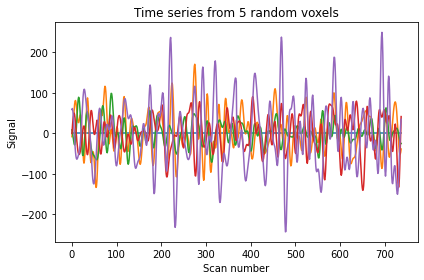

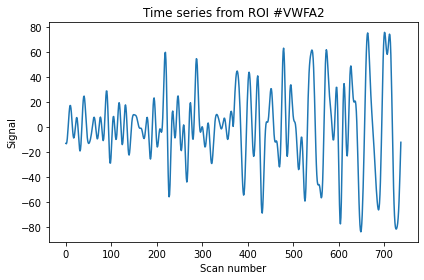

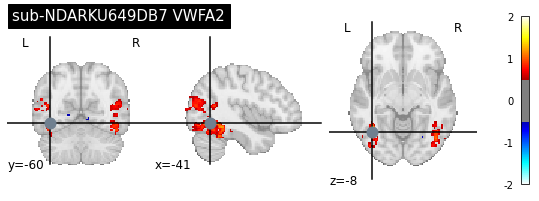

In [63]:
# Run analysis on volume
# Loop over subjects and compute connectivity for that ROI
for ii in range(len(subs)):  
    sub_dir = (inputdir + subs.iloc[ii]) # maybe we wont use that? 

    func1_file = sub_dir + func1_suffix

    if os.path.exists(func1_file):
        print('Loading data for participant ' + subs.iloc[ii])   
        run1 = image.load_img(func1_file)
        print('Original Data Volume by Timepoints')
        print(run1.shape) 
        run1 = image.index_img(run1,slice(droptp,-1))

        # Only for resting state, load second run and concatenate
        if task == 'rest':
            func2_file = str.replace(func1_file, 'run-1', 'run-2')
            if os.path.exists(func2_file):
                run2 = image.load_img(func2_file)
                run2 = image.index_img(run2,slice(droptp,-1))
                # Concatenate the 2 runs
                run_data = image.concat_imgs([run1,run2])
            else:
                run_data = run1
                print('Cant find second scan for ' + subs.iloc[ii])  
        
        elif task == 'movie':
            run_data = run1
      
        print('After dropping initial 6 Timepoints, Volume by Timepoints')
        print(run_data.shape)
        
    else:    
        print('Cant find functional scan for ' + subs.iloc[ii])
        continue

        # TBD - implement scrubbing

    # get brain-wide voxel-wise time series

    # For HBN data that was analyzed with CPAC I am not denoising with detrend
    # We do have to standardize- otherwise plots don't make sense
    brain_masker = input_data.NiftiMasker(smoothing_fwhm=None,
    detrend=False, standardize=False,
    low_pass=None, high_pass=None, t_r=t_r,
    memory=None, memory_level=1, verbose=0,
    mask_img=mask_fileName)

    # extract mean time series and regress out confounds
    # again, confounds=None becase CPAC already took care of that
    brain_time_series = brain_masker.fit_transform(run_data,confounds=None)
    print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

#         # Plot mean timeseries
    fig,ax = plt.subplots(1)
    plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000 ]])
    plt.title('Time series from 5 random voxels')
    plt.xlabel('Scan number')
    plt.ylabel('Signal')
    plt.tight_layout()

     # extract time series for each roi, 7mm sphere around coordinates
    for c in range(len(roi_coords)):

        seed_masker = input_data.NiftiSpheresMasker(
        [roi_coords[c]], radius=roi_radius,
        detrend=False, standardize=False,
        low_pass=None, high_pass=None, t_r=t_r,smoothing_fwhm=None,
        memory=None, memory_level=1, verbose=0)

        # extract mean time series 
        seed_time_series = seed_masker.fit_transform(run_data,confounds=None)

        fig,ax = plt.subplots(1)
        plt.plot(seed_time_series)
        plt.title('Time series from ROI #' + roi_names[c])
        plt.xlabel('Scan number')
        plt.ylabel('Signal')
        plt.tight_layout()

        # Calculate seed-to-voxel correlation - 
        # Original formula from nilearn tutorial
       # seed_map = (np.dot(brain_time_series.T, seed_time_series) /
        #              seed_time_series.shape[0])
        
        # Loop throught voxels and use pearson - then maybe no need to standardize?!!
        seed_map = np.zeros(brain_time_series.shape[1])
        for i in range(brain_time_series.shape[1]): # this loops through the voxels
            seed_map[i] = stats.pearsonr(seed_time_series.squeeze(), brain_time_series[:,i])[0]
        
        print("Seed-to-voxel correlation shape: (%s)" %
        seed_map.shape)
        print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (
        seed_map.min(), seed_map.max()))

        # Fisher z-transformation
        seed_map_fisherZ = np.arctanh(seed_map)
        print("Seed-to-voxel correlation Fisher-z transformed: min = %.3f; max = %.3f"
              % (seed_map_fisherZ.min(),seed_map_fisherZ.max()))

        # transform the correlation array back to a Nifti image object
        seed_map_fisherZ_img = brain_masker.inverse_transform(seed_map_fisherZ.T)
        
        # Plot image as volume - I prefer to convert to surface for visualization
        display = plotting.plot_stat_map(seed_map_fisherZ_img,
                             threshold=0.5, vmax=2,
                             cut_coords=roi_coords[c],
                             title=(subs.iloc[ii] + ' ' + roi_names[c]))
        display.add_markers(marker_coords=[roi_coords[c]], marker_color='slategray',marker_size=120)

     

In [64]:
# Test values 
sub_id = 0
# current values
nilearn_map = seed_map_fisherZ_img
nilearn_vals = nilearn_map.get_fdata().flatten()

In [17]:
# saved values
nilearn_map = image.load_img('/scratch/groups/jyeatman/HBN_FC/volume/statMaps/sub-NDARYA030ZG7_task-rest_VWFA2_zMap.nii.gz')
nilearn_vals = nilearn_map.get_fdata().flatten()
#Now load values from CONN
conn_map = image.load_img('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject081_Condition001_Source166.nii')
conn_vals = conn_map.get_fdata().flatten()

0.59048154588516 0.0


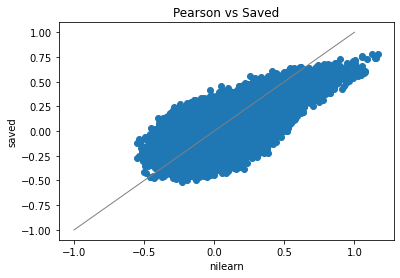

In [18]:
x = nilearn_vals
y = conn_vals

nanfilter = np.logical_and(~np.isnan(x),~np.isnan(y))
zerofilter = np.logical_and(x!=0,y!=0)
myfilter = np.logical_and(nanfilter,zerofilter)
x = x[myfilter]
y = y[myfilter]
plt.scatter(x,y)
rval,pval = stats.pearsonr(x,y)
plt.xlabel('nilearn') 
plt.ylabel('saved')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title('Pearson vs Saved')
print(rval,pval)

0.36607447981806995 0.0


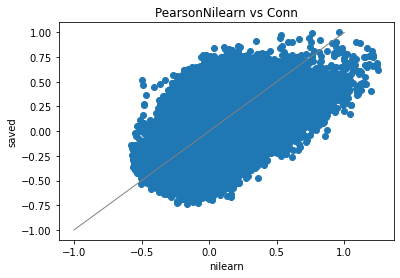

In [79]:
x = nilearn_vals
y = conn_vals

nanfilter = np.logical_and(np.isfinite(x),np.isfinite(y))
zerofilter = np.logical_and(x!=0,y!=0)
myfilter = np.logical_and(nanfilter,zerofilter)
x = x[myfilter]
y = y[myfilter]
#x = np.arctanh(np.isfinite(x))
#y = np.arctanh(y)
plt.scatter(x,y)
rval,pval = stats.pearsonr(x,y)
plt.xlabel('nilearn') 
plt.ylabel('saved')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title('PearsonNilearn vs Conn')
print(rval,pval)

In [84]:
sum(~np.isfinite(np.arctanh(x)))

/tmp/ipykernel_7547/3436747917.py:1: RuntimeWarning: invalid value encountered in arctanh
  sum(~np.isfinite(np.arctanh(x)))


81

0.5811522816759328 0.0


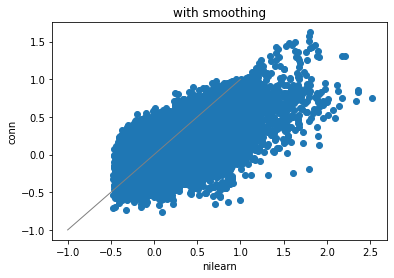

In [28]:
#Now load values from CONN
conn_map = image.load_img('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject001_Condition001_Source166.nii')
conn_vals = conn_map.get_fdata().flatten()
#conn_maps = glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject*' + 'Condition001_Source166.nii')
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title('with smoothing')
print(rval,pval)

0.9998502379134926 0.0


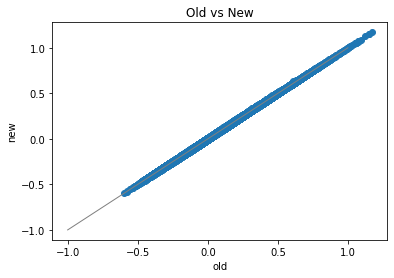

In [7]:
# saved values
sub = 'sub-NDARYA030ZG7' # Bad subject - %17 of volumes scrubbed, sub # 81
#sub = 'sub-NDARYE221LZB' # Good subject - 0 volumes scrubbed, sub # 83
old_map = image.load_img('/scratch/groups/jyeatman/HBN_FC/volume/noScrubbing/statMaps/' + sub + '_task-rest_VWFA2_zMap.nii.gz')
old_vals = old_map.get_fdata().flatten()
#Now load values from CONN
new_map = image.load_img('/scratch/groups/jyeatman/HBN_FC/volume/statMaps/' + sub + '_task-rest_VWFA2_zMap.nii.gz')
new_vals = new_map.get_fdata().flatten()

x = old_vals
y = new_vals

nanfilter = np.logical_and(~np.isnan(x),~np.isnan(y))
zerofilter = np.logical_and(x!=0,y!=0)
myfilter = np.logical_and(nanfilter,zerofilter)
x = x[myfilter]
y = y[myfilter]
plt.scatter(x,y)
rval,pval = stats.pearsonr(x,y)
plt.xlabel('old') 
plt.ylabel('new')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title('Old vs New')
print(rval,pval)

In [23]:
roi_names = ['VWFA1','VWFA2']
files_roi1 = sorted(glob.glob(datadir + 'sub-*'+task + '*' + roi_names[0] + '*zMap.nii.gz'), key=os.path.basename) # this gets the full path
files_roi2 = sorted(glob.glob(datadir + 'sub-*'+task + '*' + roi_names[1] + '*zMap.nii.gz'), key=os.path.basename) # this gets the full path
# we have to sort, otherwise lists have different orders


In [25]:
# Test values from CONN
corr_df = pd.DataFrame()
conn_maps = sorted(glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject*' + 'Condition001_Source166.nii'),key=os.path.basename)
rval_group = np.empty(len(conn_maps))
pval_group = np.empty(len(conn_maps))
sub_files = []

for sub_id in range(len(conn_maps)):
    
#for sub_id in range(1):
    #'BETA_Subject%s_Condition001_Source166.nii
    conn_map = image.load_img(conn_maps[sub_id])
    conn_vals = conn_map.get_fdata().flatten()
    #conn_maps = glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject*' + 'Condition001_Source166.nii')
    nilearn_map = image.load_img(files_roi2[sub_id])
   # print(files_roi2[sub_id])
    nilearn_vals = nilearn_map.get_fdata().flatten()
  #  plt.scatter(nilearn_vals,conn_vals)
    nanfilter = np.logical_and(~np.isnan(nilearn_vals),~np.isnan(conn_vals))
    zerofilter = np.logical_and(nilearn_vals!=0,conn_vals!=0)
    myfilter = np.logical_and(nanfilter,zerofilter)
    nilearn_vals = nilearn_vals[myfilter]
    conn_vals = conn_vals[myfilter]
  #  plt.scatter(nilearn_vals,conn_vals)
    rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
    #print('subject ' + str(sub_id) + 'r: '+ str(rval) + ',p: ' + str(pval))
    rval_group[sub_id] = rval
    pval_group[sub_id] = pval
    sub_files.append(os.path.basename(files_roi2[sub_id]))
corr_df['sub'] = sub_files
corr_df['rval'] = rval_group
corr_df['pval'] = pval_group
    

In [26]:
corr_df

,sub,rval,pval
0,sub-NDARAA948VFH_task-rest_VWFA2_zMap.nii.gz,0.823844,0.0
1,sub-NDARAC350BZ0_task-rest_VWFA2_zMap.nii.gz,0.815391,0.0
2,sub-NDARBF851NH6_task-rest_VWFA2_zMap.nii.gz,0.911827,0.0
3,sub-NDARBJ159HXB_task-rest_VWFA2_zMap.nii.gz,0.759513,0.0
4,sub-NDARBR740NKV_task-rest_VWFA2_zMap.nii.gz,0.901237,0.0
...,...,...,...
85,sub-NDARZF170TZ0_task-rest_VWFA2_zMap.nii.gz,0.698064,0.0
86,sub-NDARZM903TNL_task-rest_VWFA2_zMap.nii.gz,0.790762,0.0
87,sub-NDARZT940RZG_task-rest_VWFA2_zMap.nii.gz,0.587208,0.0
88,sub-NDARZW873DN3_task-rest_VWFA2_zMap.nii.gz,0.728137,0.0


(array([ 1.,  1.,  1.,  7.,  5.,  8., 17., 23., 18.,  9.]),
 array([0.36607448, 0.42156469, 0.47705491, 0.53254512, 0.58803533,
        0.64352554, 0.69901575, 0.75450597, 0.80999618, 0.86548639,
        0.9209766 ]),
 <BarContainer object of 10 artists>)

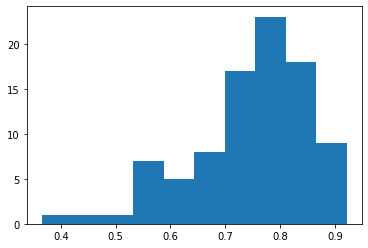

In [27]:
plt.hist(corr_df['rval'])

In [30]:
corr_df.sort_values('rval')

,sub,rval,pval
37,sub-NDARKU649DB7_task-rest_VWFA2_zMap.nii.gz,0.366074,0.0
36,sub-NDARKN633WZA_task-rest_VWFA2_zMap.nii.gz,0.440535,0.0
64,sub-NDARVC195NLH_task-rest_VWFA2_zMap.nii.gz,0.498020,0.0
57,sub-NDARTD925CTP_task-rest_VWFA2_zMap.nii.gz,0.553954,0.0
10,sub-NDARDE283PLC_task-rest_VWFA2_zMap.nii.gz,0.559705,0.0
...,...,...,...
48,sub-NDARNF873FCV_task-rest_VWFA2_zMap.nii.gz,0.895569,0.0
76,sub-NDARXR346UT5_task-rest_VWFA2_zMap.nii.gz,0.896500,0.0
4,sub-NDARBR740NKV_task-rest_VWFA2_zMap.nii.gz,0.901237,0.0
2,sub-NDARBF851NH6_task-rest_VWFA2_zMap.nii.gz,0.911827,0.0


In [31]:
subs

0    sub-NDARAA948VFH
Name: participant_id, dtype: object